In [1]:
from pathlib import Path
import os
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.integrate import solve_ivp
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_log_error, mean_squared_error

from pmdarima.arima import auto_arima

/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
app_dir = '/Users/paramshah/Documents/Param/NYU/courses/Machine Learning/Project/Github Team/covid-19'

In [3]:
_type = 'cases'

In [4]:
df = pd.read_csv(os.path.join(app_dir, f'data/staging/jhu_{_type}.csv'))
df['date'] = pd.to_datetime(df['date'])

In [5]:
countries = df.country.unique()

In [6]:
for country in countries:
    print(country)

United States
India
Italy
Canada
Spain
France
United Kingdom
Iraq
Japan
Germany
Brazil


In [7]:
df[(df['country'] == "United States") & (df[_type] != 0)]

,country,date,cases,cases_lag_1,cases_lag_2,cases_lag_3,cases_lag_4,cases_lag_5,cases_lag_6,cases_lag_7,...,cases_lag_10,cases_lag_11,cases_lag_12,cases_lag_13,cases_lag_14,cases_lag_15,cases_lag_16,cases_lag_17,cases_lag_18,cases_lag_19
0,United States,2020-01-22,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,United States,2020-01-23,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,United States,2020-01-24,2,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,United States,2020-01-25,2,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,United States,2020-01-26,5,2,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,United States,2020-05-10,1329260,1309550,1283929,1257023,1229331,1204351,1180375,1158040,...,1069424,1039909,1012582,988197,965785,938154,905358,869170,840351,811865
110,United States,2020-05-11,1347881,1329260,1309550,1283929,1257023,1229331,1204351,1180375,...,1103461,1069424,1039909,1012582,988197,965785,938154,905358,869170,840351
111,United States,2020-05-12,1369376,1347881,1329260,1309550,1283929,1257023,1229331,1204351,...,1132539,1103461,1069424,1039909,1012582,988197,965785,938154,905358,869170
112,United States,2020-05-13,1390406,1369376,1347881,1329260,1309550,1283929,1257023,1229331,...,1158040,1132539,1103461,1069424,1039909,1012582,988197,965785,938154,905358


In [8]:
df['date'].unique()

array(['2020-01-22T00:00:00.000000000', '2020-01-23T00:00:00.000000000',
       '2020-01-24T00:00:00.000000000', '2020-01-25T00:00:00.000000000',
       '2020-01-26T00:00:00.000000000', '2020-01-27T00:00:00.000000000',
       '2020-01-28T00:00:00.000000000', '2020-01-29T00:00:00.000000000',
       '2020-01-30T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2020-02-01T00:00:00.000000000', '2020-02-02T00:00:00.000000000',
       '2020-02-03T00:00:00.000000000', '2020-02-04T00:00:00.000000000',
       '2020-02-05T00:00:00.000000000', '2020-02-06T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000', '2020-02-08T00:00:00.000000000',
       '2020-02-09T00:00:00.000000000', '2020-02-10T00:00:00.000000000',
       '2020-02-11T00:00:00.000000000', '2020-02-12T00:00:00.000000000',
       '2020-02-13T00:00:00.000000000', '2020-02-14T00:00:00.000000000',
       '2020-02-15T00:00:00.000000000', '2020-02-16T00:00:00.000000000',
       '2020-02-17T00:00:00.000000000', '2020-02-18

In [9]:
dates = df[(df['date'] >= '2020-02-15') & (df['date'] <= '2020-05-09')]['date'].unique()

In [10]:
n_periods = 10
column_names = ["country", "date"]

for i in range(n_periods):
    column_names.append(f"date+{i+1}_pred")
for i in range(n_periods):
    column_names.append(f"date+{i+1}_linf")
for i in range(n_periods):
    column_names.append(f"date+{i+1}_lsup")

In [11]:
column_names

['country',
 'date',
 'date+1_pred',
 'date+2_pred',
 'date+3_pred',
 'date+4_pred',
 'date+5_pred',
 'date+6_pred',
 'date+7_pred',
 'date+8_pred',
 'date+9_pred',
 'date+10_pred',
 'date+1_linf',
 'date+2_linf',
 'date+3_linf',
 'date+4_linf',
 'date+5_linf',
 'date+6_linf',
 'date+7_linf',
 'date+8_linf',
 'date+9_linf',
 'date+10_linf',
 'date+1_lsup',
 'date+2_lsup',
 'date+3_lsup',
 'date+4_lsup',
 'date+5_lsup',
 'date+6_lsup',
 'date+7_lsup',
 'date+8_lsup',
 'date+9_lsup',
 'date+10_lsup']

In [12]:
# column_names = [
#     "country", "date", 
#     "date+1_pred",
#     "date+2_pred",
#     "date+3_pred",
#     "date+4_pred",
#     "date+5_pred",
#     "date+6_pred",
#     "date+7_pred",
#     "date+8_pred",
#     "date+9_pred",
#     "date+10_pred",
#     "date+1_linf",
#     "date+2_linf",
#     "date+3_linf",
#     "date+4_linf",
#     "date+5_linf",
#     "date+6_linf",
#     "date+7_linf",
#     "date+8_linf",
#     "date+9_linf",
#     "date+10_linf",
#     "date+1_lsup",
#     "date+2_lsup",
#     "date+3_lsup",
#     "date+4_lsup",
#     "date+5_lsup",
#     "date+6_lsup",
#     "date+7_lsup",
#     "date+8_lsup",
#     "date+9_lsup",
#     "date+10_lsup"
# ]
df_preds = pd.DataFrame(columns = column_names)

In [13]:
predictions = {}

countries = list(countries)
i = 0
for country in countries:
    predictions[country] = {}
#     if country != 'Canada':
#         print(country)
    for date in dates:
        data_for_prediction = df[(df['country'] == country) & (df['date'] < date)]
        cases = data_for_prediction.sort_values(by=['date'])[_type].dropna().values
        try:
            model = auto_arima(cases, start_p=0, start_q=0,
                                  test='adf',       # use adftest to find optimal 'd'
                                  max_p=12, max_q=12, # maximum p and q
                                  m=1,              # frequency of series
                                  d=None,           # let model determine 'd'
                                  seasonal=False,   # No Seasonality
                                  start_P=0, 
                                  D=0, with_intercept=False,
                                  trace=False,
                                  error_action='ignore',  
                                  suppress_warnings=True, 
                                  stepwise=True)
        except:
            print(f"Did not work for {country} at date {date}")
            continue

        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.2)
        # make series for plotting purpose
        fc = pd.DataFrame(fc,columns = ['Prediction'])

        lower_series = pd.DataFrame(confint[:, 0],columns = ['Linf'])
        upper_series = pd.DataFrame(confint[:, 1],columns = ['Lsup'])

        date2 = data_for_prediction['date'][-n_periods:] + pd.DateOffset(days=n_periods)
        try_df = pd.DataFrame({'index':date2.index, 'date':date2.values})

        fc=pd.concat([fc,lower_series,upper_series,try_df['date']],axis=1)
        fc.set_index([ 'date'], inplace=True)

        train = data_for_prediction.copy()
        train.set_index(['date'], inplace=True)
        train=train.dropna()

        actual = df[(df['country'] == country) & (df['date'] >= date2.values[0]) & (df['date'] <= date2.values[-1])]
        actual = actual.set_index(['date'])

        predictions[country][date] = {}
        predictions[country][date]['dates'] = fc.index.values
        predictions[country][date]['Predictions'] = fc.Prediction.values
        predictions[country][date]['Linfs'] = fc.Linf.values
        predictions[country][date]['Lsups'] = fc.Lsup.values
        predictions[country][date]['actuals'] = actual[_type].values
        
        df_preds.loc[i] = [country, date] + list(fc.Prediction.values) + list(fc.Linf.values) + list(fc.Lsup.values)
        i+=1

/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/s

Did not work for Iraq at date 2020-02-15T00:00:00.000000000
Did not work for Iraq at date 2020-02-16T00:00:00.000000000
Did not work for Iraq at date 2020-02-17T00:00:00.000000000
Did not work for Iraq at date 2020-02-18T00:00:00.000000000
Did not work for Iraq at date 2020-02-19T00:00:00.000000000
Did not work for Iraq at date 2020-02-20T00:00:00.000000000
Did not work for Iraq at date 2020-02-21T00:00:00.000000000
Did not work for Iraq at date 2020-02-22T00:00:00.000000000
Did not work for Iraq at date 2020-02-23T00:00:00.000000000
Did not work for Iraq at date 2020-02-24T00:00:00.000000000
Did not work for Iraq at date 2020-02-25T00:00:00.000000000
Did not work for Iraq at date 2020-02-26T00:00:00.000000000
Did not work for Iraq at date 2020-02-27T00:00:00.000000000


/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/anaconda3/envs/ml_project/lib/python3.7/s

Did not work for Brazil at date 2020-02-15T00:00:00.000000000
Did not work for Brazil at date 2020-02-16T00:00:00.000000000
Did not work for Brazil at date 2020-02-17T00:00:00.000000000
Did not work for Brazil at date 2020-02-18T00:00:00.000000000
Did not work for Brazil at date 2020-02-19T00:00:00.000000000
Did not work for Brazil at date 2020-02-20T00:00:00.000000000
Did not work for Brazil at date 2020-02-21T00:00:00.000000000
Did not work for Brazil at date 2020-02-22T00:00:00.000000000
Did not work for Brazil at date 2020-02-23T00:00:00.000000000
Did not work for Brazil at date 2020-02-24T00:00:00.000000000
Did not work for Brazil at date 2020-02-25T00:00:00.000000000
Did not work for Brazil at date 2020-02-26T00:00:00.000000000
Did not work for Brazil at date 2020-02-27T00:00:00.000000000
Did not work for Brazil at date 2020-02-28T00:00:00.000000000
Did not work for Brazil at date 2020-02-29T00:00:00.000000000


In [14]:
df_preds.head(10)

,country,date,date+1_pred,date+2_pred,date+3_pred,date+4_pred,date+5_pred,date+6_pred,date+7_pred,date+8_pred,...,date+1_lsup,date+2_lsup,date+3_lsup,date+4_lsup,date+5_lsup,date+6_lsup,date+7_lsup,date+8_lsup,date+9_lsup,date+10_lsup
0,United States,2020-02-15,13.545405,14.090811,14.636216,15.181621,15.727026,16.272432,16.817837,17.363242,...,14.759376,15.807702,16.739065,17.609892,18.442038,19.246712,20.030571,20.797955,21.551874,22.294524
1,United States,2020-02-16,13.521704,14.043408,14.565112,15.086816,15.608520,16.130223,16.651927,17.173631,...,14.716797,15.733582,16.635213,17.477244,18.281190,19.058085,19.814486,20.554663,21.281582,21.997402
2,United States,2020-02-17,13.497979,13.995959,14.493938,14.991918,15.489897,15.987876,16.485856,16.983835,...,14.676967,15.666313,16.543389,17.362687,18.145272,18.901927,19.639045,20.360786,21.070031,21.768878
3,United States,2020-02-18,13.412330,13.824660,14.236990,14.649320,15.061650,15.473980,15.886310,16.298640,...,14.594879,15.539888,16.390573,17.197521,17.979766,18.746793,19.504072,20.255060,21.002083,21.746777
4,United States,2020-02-19,13.350428,13.700857,14.051285,14.401713,14.752142,15.102570,15.452998,15.803427,...,14.519717,15.411574,16.217060,16.984722,17.732617,18.469632,19.200820,19.929326,20.657226,21.385954
5,United States,2020-02-20,13.299297,13.598595,13.897892,14.197190,14.496487,14.795784,15.095082,15.394379,...,14.452685,15.295522,16.057627,16.785945,17.497791,18.201611,18.902155,19.602343,20.304076,21.008645
6,United States,2020-02-21,13.256629,13.513258,13.769887,14.026516,14.283145,14.539773,14.796402,15.053031,...,14.393206,15.192063,15.914491,16.606093,17.283587,17.955067,18.625048,19.296277,19.970524,20.648972
7,United States,2020-02-22,15.413866,15.827733,16.241599,16.655466,17.069332,17.483199,17.897065,18.310932,...,16.566717,17.458147,18.238487,18.961326,19.647422,20.307420,20.947644,21.572213,22.183990,22.785057
8,United States,2020-02-23,15.466577,15.933155,16.399732,16.866309,17.332887,17.799464,18.266041,18.732619,...,16.605211,17.543579,18.372278,19.144226,19.879917,20.589861,21.280301,21.955305,22.617696,23.269531
9,United States,2020-02-24,15.424993,15.849986,16.274979,16.699971,17.124964,17.549957,17.974950,18.399943,...,16.563131,17.482114,18.301665,19.072358,19.813482,20.534784,21.241970,21.938702,22.627487,23.310121


In [17]:
df_preds.to_csv('test.csv')

In [16]:
for key, val in predictions.items():
    print(key)

United States
India
Italy
Canada
Spain
France
United Kingdom
Iraq
Japan
Germany
Brazil


In [212]:
fc

,Prediction,Linf,Lsup
date,,,
2020-05-09,224003.545378,221698.476692,226308.614064
2020-05-10,225211.946630,221602.562831,228821.330429
2020-05-11,226405.824891,221251.103671,231560.546111
2020-05-12,227603.112970,220772.465069,234433.760871
2020-05-13,228799.600466,220149.515449,237449.685483
2020-05-14,229996.275929,219396.085644,240596.466213
2020-05-15,231192.907260,218518.512508,243867.302011
2020-05-16,232389.548952,217523.600951,247255.496953
2020-05-17,233586.188212,216416.997441,250755.378983


In [213]:
actual

,country,cases
date,,
2020-05-09,Spain,223578
2020-05-10,Spain,224350
2020-05-11,Spain,227436
2020-05-12,Spain,228030
2020-05-13,Spain,228691
2020-05-14,Spain,229540


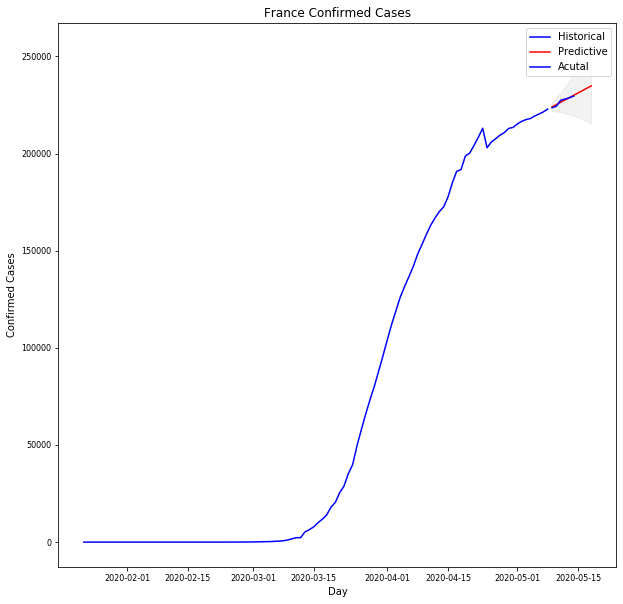

In [214]:
# Plot
plt.figure(figsize=(10,10))

plt.title(f'{country} Confirmed Cases')
plt.plot(train[_type],label='Historical',color='blue')
plt.plot(fc.Prediction,label='Predictive',color='red')
plt.plot(actual[_type],label='Acutal',color='blue')
plt.fill_between(fc.index, 
                 fc.Linf, 
                 fc.Lsup, 
                 color='k', alpha=.05)
plt.xlabel('Day',fontsize=10)
plt.ylabel('Confirmed Cases',fontsize=10)
plt.xticks(rotation=0,fontsize=8)
plt.yticks(fontsize=8)
# plt.yscale('log')
plt.legend()


plt.show()